# Install the appropriate packages

In [3]:
from google.cloud import storage
import pandas as pd ## for dataset and eda
import numpy as np ## for eda
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from wordcloud import WordCloud
from uszipcode import SearchEngine


%matplotlib inline


In [5]:
bucket_name = "deepl1"

storage_client = storage.Client()
bucket = storage_client.get_bucket(bucket_name)

print(bucket)
print('Great, we now have access to our first bucket on google cloud storage where we put our data')

<Bucket: deepl1>
Great, we now have access to our first bucket on google cloud storage where we put our data


# Read the datasets from google cloud storage

In [3]:
from google.cloud import storage
import pandas as pd

bucket_name = "firstprojectdl"

storage_client = storage.Client()
bucket = storage_client.get_bucket(bucket_name)

# When you have your files in a subfolder of the bucket.
my_prefix = "data/movieLens/movieLens100k/" # the name of the subfolder
blobs = bucket.list_blobs(prefix = my_prefix, delimiter = '/')

dfDict = {}
dateparse = lambda x: datetime.utcfromtimestamp(int(x)).strftime('%Y-%m-%d %H:%M:%S')

for blob in blobs:
    if(blob.name != my_prefix): # ignoring the subfolder itself 
        file_name = blob.name.replace(my_prefix, "")
        blob.download_to_filename(file_name) # download the file to the machine
        print(file_name)
        if file_name =='u.data':
            df = pd.read_csv(file_name, sep='\t', 
                            names=['user_id', 'movie_id', 'rating', 'timestamp'], 
                            parse_dates=['timestamp'], 
                            date_parser=dateparse) # load the rating data
        elif file_name == 'u.item':
            df = pd.read_csv('u.item', sep='|', encoding='latin-1',
                    names=['movie_id', 'movie_title', 'release_date', 'video_release_date', 'imdb_url', 'unknown', 'action', 
                           'adventure', 'animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 
                           'film_noir', 'horror', 'musical', 'mystery', 'romance', 'sci_fi', 'thriller', 'war', 'western']) # load the movie data
        elif file_name == 'u.user':
            df = pd.read_csv('u.user', sep='|', encoding='latin-1',
                     names=['user_id', 'age', 'gender', 'occupation', 'zip_code']) # user_df
        dfDict[file_name] = df
        



dfDict['rating'] = dfDict['u.data'] 
del dfDict['u.data'] 
        
dfDict['movie'] = dfDict['u.item'] 
del dfDict['u.item'] 

dfDict['user'] = dfDict['u.user'] 
del dfDict['u.user'] 

## This is the list of datasets we have for the movieLens 100k!!
print(list(dfDict))

u.data
u.item
u.user
['rating', 'movie', 'user']


In [4]:
rating = dfDict['rating']
movie = dfDict['movie']
user = dfDict['user']


In [5]:
rating.head()

,user_id,movie_id,rating,timestamp
0,196,242,3,1997-12-04 15:55:49
1,186,302,3,1998-04-04 19:22:22
2,22,377,1,1997-11-07 07:18:36
3,244,51,2,1997-11-27 05:02:03
4,166,346,1,1998-02-02 05:33:16


In [7]:
movie.head()

,movie_id,movie_title,release_date,video_release_date,imdb_url,unknown,action,adventure,animation,childrens,...,fantasy,film_noir,horror,musical,mystery,romance,sci_fi,thriller,war,western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [8]:
user.head()

,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


# Explore the movie dataset

In [10]:
movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1682 entries, 0 to 1681
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   movie_id            1682 non-null   int64  
 1   movie_title         1682 non-null   object 
 2   release_date        1681 non-null   object 
 3   video_release_date  0 non-null      float64
 4   imdb_url            1679 non-null   object 
 5   unknown             1682 non-null   int64  
 6   action              1682 non-null   int64  
 7   adventure           1682 non-null   int64  
 8   animation           1682 non-null   int64  
 9   childrens           1682 non-null   int64  
 10  comedy              1682 non-null   int64  
 11  crime               1682 non-null   int64  
 12  documentary         1682 non-null   int64  
 13  drama               1682 non-null   int64  
 14  fantasy             1682 non-null   int64  
 15  film_noir           1682 non-null   int64  
 16  horror

# 

In [11]:
movie.describe()

,movie_id,video_release_date,unknown,action,adventure,animation,childrens,comedy,crime,documentary,...,fantasy,film_noir,horror,musical,mystery,romance,sci_fi,thriller,war,western
count,1682.000000,0.0,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,...,1682.00000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000
mean,841.500000,NaN,0.001189,0.149227,0.080262,0.024970,0.072533,0.300238,0.064804,0.029727,...,0.01308,0.014269,0.054697,0.033294,0.036266,0.146849,0.060048,0.149227,0.042212,0.016052
std,485.695893,NaN,0.034473,0.356418,0.271779,0.156081,0.259445,0.458498,0.246253,0.169882,...,0.11365,0.118632,0.227455,0.179456,0.187008,0.354061,0.237646,0.356418,0.201131,0.125714
min,1.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,421.250000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,841.500000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1261.750000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1682.000000,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
## video release date does not have any non null values
## release date needs to be parsed to datetime
## no need for the imdb url

In [13]:
movie.loc[:, 'release_date'] = pd.to_datetime(movie['release_date'])
#movie['release_date']

In [14]:
##  Checkout NaN values percent in each column
def check_nan_percent(df):
    columns_null_count = df.isnull().sum()
    null_percent_df = pd.DataFrame({'null_percent': (columns_null_count/df.shape[0])*100, 'total_null': columns_null_count})
    return null_percent_df[null_percent_df.null_percent>0]

In [15]:
check_nan_percent(movie)

,null_percent,total_null
release_date,0.059453,1
video_release_date,100.000000,1682
imdb_url,0.178359,3


In [16]:
##removing video release date and imdb_url because they are unecessary
## we fill the missing value in release date by the mode
movie.drop(columns=['video_release_date', 'imdb_url'], inplace=True)
movie.release_date.fillna(value=movie.release_date.mode()[0], inplace=True)

check_nan_percent(movie)

,null_percent,total_null


In [17]:
movie.head()

,movie_id,movie_title,release_date,unknown,action,adventure,animation,childrens,comedy,crime,...,fantasy,film_noir,horror,musical,mystery,romance,sci_fi,thriller,war,western
0,1,Toy Story (1995),1995-01-01,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),1995-01-01,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),1995-01-01,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),1995-01-01,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),1995-01-01,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


# Explore rating!

In [18]:
rating.head()

,user_id,movie_id,rating,timestamp
0,196,242,3,1997-12-04 15:55:49
1,186,302,3,1998-04-04 19:22:22
2,22,377,1,1997-11-07 07:18:36
3,244,51,2,1997-11-27 05:02:03
4,166,346,1,1998-02-02 05:33:16


In [19]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   user_id    100000 non-null  int64         
 1   movie_id   100000 non-null  int64         
 2   rating     100000 non-null  int64         
 3   timestamp  100000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 3.1 MB


In [20]:
rating.describe()

,user_id,movie_id,rating
count,100000.00000,100000.000000,100000.000000
mean,462.48475,425.530130,3.529860
std,266.61442,330.798356,1.125674
min,1.00000,1.000000,1.000000
25%,254.00000,175.000000,3.000000
50%,447.00000,322.000000,4.000000
75%,682.00000,631.000000,4.000000
max,943.00000,1682.000000,5.000000


All good with the ratings

In [21]:
check_nan_percent(rating)

,null_percent,total_null


# Explore the user set

zip codes will be converted in town names

In [22]:
search = SearchEngine(simple_zipcode=True)

In [23]:
user['city'] = user['zip_code'].apply(lambda zip: search.by_zipcode(zip).major_city)
print(user['city'])

0               Tucson
1        Mountain View
2          Orange Park
3               Maumee
4           Pittsburgh
            ...       
938    Fort Lauderdale
939             Boston
940           Portland
941        San Antonio
942    College Station
Name: city, Length: 943, dtype: object


In [24]:
user.describe()

,user_id,age
count,943.000000,943.000000
mean,472.000000,34.051962
std,272.364951,12.192740
min,1.000000,7.000000
25%,236.500000,25.000000
50%,472.000000,31.000000
75%,707.500000,43.000000
max,943.000000,73.000000


In [25]:
check_nan_percent(user)

,null_percent,total_null
city,3.923648,37


37 zip codes could not be converted, we shall investigate 

In [26]:
user[user['city'].isnull()]

,user_id,age,gender,occupation,zip_code,city
53,54,22,M,executive,66315,None
72,73,24,M,student,41850,None
73,74,39,M,scientist,T8H1N,None
85,86,26,M,administrator,46005,None
144,145,31,M,entertainment,V3N4P,None
166,167,37,M,other,L9G2B,None
185,186,39,F,executive,00000,None
193,194,38,M,administrator,02154,None
200,201,27,M,writer,E2A4H,None
332,333,47,M,other,V0R2M,None


the zip codes are actually invalid and we will not remove them and rather will apply the mode for imputation

In [27]:
user.city.fillna(value=user.city.mode()[0], inplace=True)

In [28]:
check_nan_percent(user)

,null_percent,total_null


no more missing values since the 37 zip codes have been imputed

Let us now explore the potential insights of this dataset

Let us check what is the common genre of the movie, how many movies got released each year and month, and the preferrable week of month to release movies.

In [29]:
user.age.min()

7

In [30]:
user.age.max()

73

We will have the following age categories for further age based data exploration

In [31]:
user['age_group'] = user.age.apply(lambda age: 'Gradeschooler' if 5<=age<=12 else ('Teenager' if 13<=age<=19 else ('Young' if 20<=age<=35 else ('Midlife' if 35<=age<=55 else 'Old'))))
user.sample(5)


,user_id,age,gender,occupation,zip_code,city,age_group
62,63,31,M,marketing,75240,Dallas,Young
552,553,58,M,educator,62901,Carbondale,Old
252,253,26,F,librarian,22903,Charlottesville,Young
237,238,42,F,administrator,44124,Cleveland,Midlife
333,334,32,M,librarian,30002,Avondale Estates,Young


Let us also join all 3 datasets to explore insights between ratings, movies, and user

In [32]:
rating_user_df = rating.join(other=user, how='inner', on='user_id', lsuffix='_R')
rating_user_movie_df = rating_user_df.join(other=movie, how='inner', on='movie_id', rsuffix='_M')
rating_movie_df = rating.join(other=movie, how='inner', on='movie_id', rsuffix='_M')

In [33]:
rating_user_df.sample(5)

,user_id_R,movie_id,rating,timestamp,user_id,age,gender,occupation,zip_code,city,age_group
73299,707,648,4,1998-01-31 22:30:24,708,26,F,homemaker,96349,Minneapolis,Young
36224,533,193,4,1997-11-13 16:42:59,534,20,M,student,05464,Jeffersonville,Young
46639,643,155,2,1998-04-01 16:49:05,644,51,M,retired,63645,Fredericktown,Midlife
37391,547,347,4,1998-03-30 18:31:20,548,51,M,writer,95468,Point Arena,Midlife
93591,13,793,5,1997-12-14 23:24:01,14,45,M,scientist,55106,Saint Paul,Midlife


In [34]:
rating_user_movie_df.sample(5)

,user_id_R,movie_id,rating,timestamp,user_id,age,gender,occupation,zip_code,city,...,fantasy,film_noir,horror,musical,mystery,romance,sci_fi,thriller,war,western
18726,387,69,3,1998-02-03 04:33:33,388,31,M,other,36106,Montgomery,...,0,0,0,0,0,1,0,0,0,0
49223,60,513,5,1997-12-28 16:19:54,61,36,M,engineer,30040,Cumming,...,0,0,0,0,0,1,0,0,0,0
21135,160,169,4,1997-10-14 20:47:57,161,50,M,lawyer,55104,Saint Paul,...,0,0,0,0,0,1,0,0,0,0
24663,371,265,5,1997-11-25 05:25:44,372,25,F,student,66046,Lawrence,...,0,0,0,0,0,0,0,0,0,0
60151,862,1011,5,1997-11-12 02:52:03,863,17,M,student,60089,Buffalo Grove,...,0,0,0,0,0,0,0,0,0,0


In [35]:
rating_movie_df

,user_id,movie_id,rating,timestamp,movie_id_M,movie_title,release_date,unknown,action,adventure,...,fantasy,film_noir,horror,musical,mystery,romance,sci_fi,thriller,war,western
0,196,242,3,1997-12-04 15:55:49,243,Jungle2Jungle (1997),1997-03-07,0,0,0,...,0,0,0,0,0,0,0,0,0,0
253,63,242,3,1997-10-01 23:06:30,243,Jungle2Jungle (1997),1997-03-07,0,0,0,...,0,0,0,0,0,0,0,0,0,0
629,226,242,5,1998-01-04 04:37:51,243,Jungle2Jungle (1997),1997-03-07,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1232,154,242,3,1997-11-10 05:03:55,243,Jungle2Jungle (1997),1997-03-07,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2159,306,242,5,1997-10-10 17:16:33,243,Jungle2Jungle (1997),1997-03-07,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96444,840,1674,4,1998-03-29 22:48:02,1675,"Sunchaser, The (1996)",1996-10-25,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97649,655,1640,3,1998-02-26 06:30:46,1641,Dadetown (1995),1996-09-18,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98427,655,1637,3,1998-03-04 04:04:15,1638,Normal Life (1996),1996-10-25,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98640,655,1630,3,1998-02-14 03:58:55,1631,"Slingshot, The (1993)",1993-01-01,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Then, let us check what the common genres of movies are:

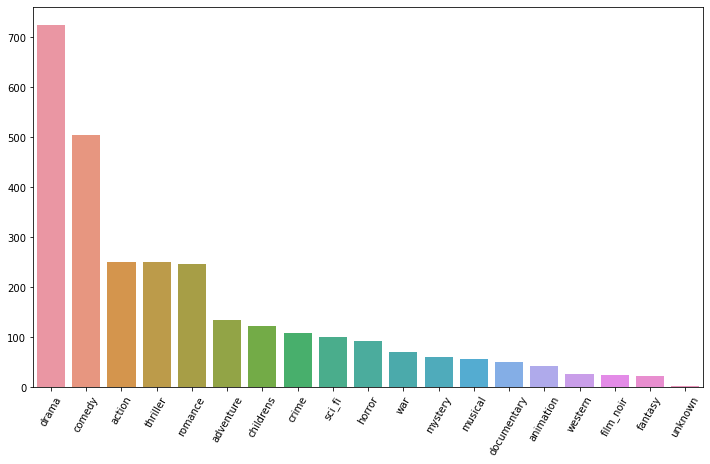

In [36]:
genres = ['unknown', 'action',
       'adventure', 'animation', 'childrens', 'comedy', 'crime', 'documentary',
       'drama', 'fantasy', 'film_noir', 'horror', 'musical', 'mystery',
       'romance', 'sci_fi', 'thriller', 'war', 'western']
plt.figure(figsize=(12,7))
genres_count = movie.loc[:,genres].sum().sort_values(ascending=False)
sns.barplot(x=genres_count.index, y=genres_count.values)
plt.xticks(rotation=60);

Most popular genres are drama and comedy!

How many movies got released over time?

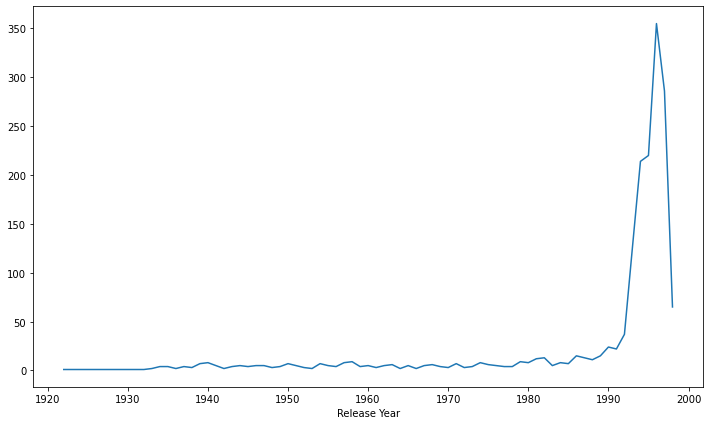

In [37]:
plt.figure(figsize=(12,7))
yearly_release_counts = movie.groupby(movie.release_date.dt.year).size().sort_values(ascending=False)
sns.lineplot(x=yearly_release_counts.index, y=yearly_release_counts.values);
plt.xlabel('Release Year');

Most of the release occured in the 1990's and we certainly have incomplete data at the end of that decade. Now we can go into an analysis of the release per month and only in the 1990's given this is where most of the movies have have been released.

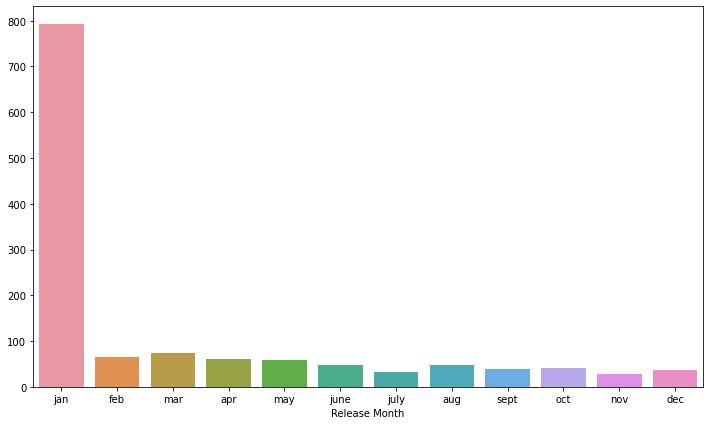

In [38]:
plt.figure(figsize=(12,7))
monthly_release_counts = movie[movie.release_date.dt.year > 1990].groupby(movie.release_date.dt.month).size()
sns.barplot(x=['jan', 'feb', 'mar', 'apr', 'may', 'june', 'july', 'aug', 'sept', 'oct', 'nov', 'dec'], y=monthly_release_counts.values);
plt.xlabel('Release Month');

it is likely the release date are biased and not reliable, because it would be weird to think that most movies are released on January

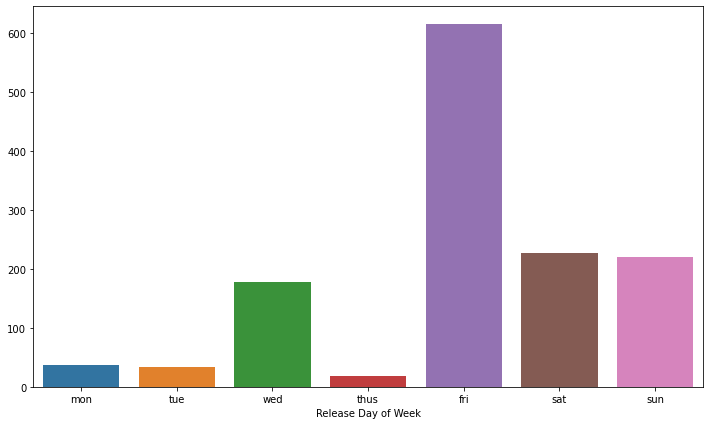

In [39]:
plt.figure(figsize=(12,7))
weekday_release_counts = movie[movie.release_date.dt.year > 1990].groupby(movie.release_date.dt.dayofweek).size()
sns.barplot(x= ['mon', 'tue', 'wed', 'thus', 'fri', 'sat', 'sun'], y=weekday_release_counts.values);
plt.xlabel('Release Day of Week');

It is logical most movies got released on Fridays and then on week ends

Movie watching in terms of gender

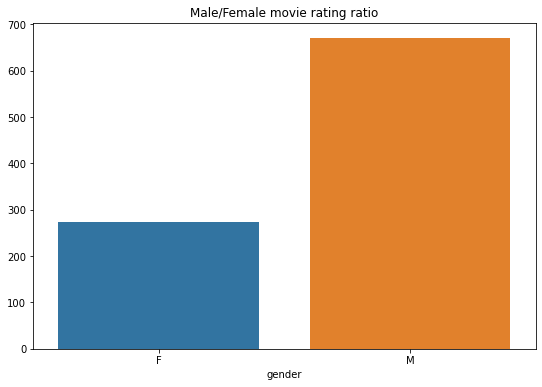

In [40]:
plt.figure(figsize=(9,6))
sns.barplot(x=user.groupby('gender').size().index, y=user.groupby('gender').size().values)
plt.title('Male/Female movie rating ratio');

Age group analysis

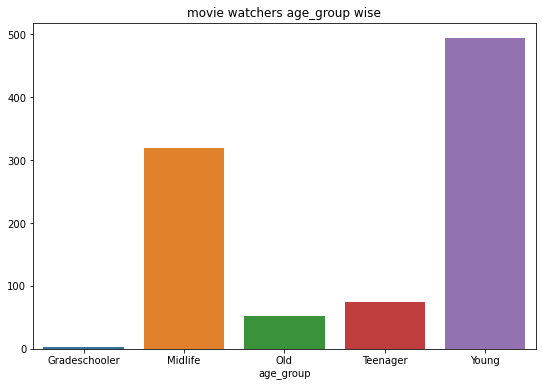

In [41]:
plt.figure(figsize=(9,6))
sns.barplot(x=user.groupby('age_group').size().index, y=user.groupby('age_group').size().values)
plt.title('movie watchers age_group wise');


Job Occupation analysis

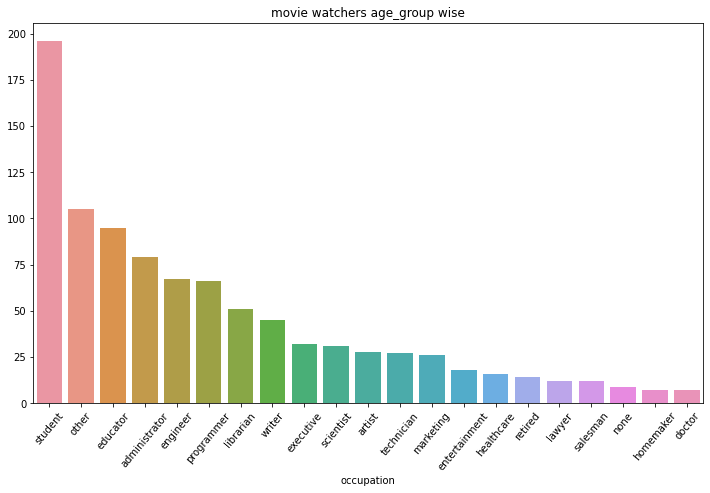

In [42]:
plt.figure(figsize=(12,7))
movie_watcher_occupants = user.groupby('occupation').size().sort_values(ascending=False)
sns.barplot(x=movie_watcher_occupants.index, y=movie_watcher_occupants.values)
plt.title('movie watchers age_group wise')
plt.xticks(rotation=50);

Students watch a lot of movies

In [43]:
pd.DataFrame(user.groupby(['occupation', 'age_group']).size().sort_values(ascending=False))

0
occupation age_group         
student    Young          128
           Teenager        62
other      Young           59
educator   Midlife         51
programmer Young           45
...                       ...
artist     Teenager         1
none       Gradeschooler    1
salesman   Teenager         1
retired    Midlife          1
none       Midlife          1

[62 rows x 1 columns]

Gender vs Genres analysis

In [44]:
temp_df = rating_user_movie_df.groupby('gender').sum().loc[:,genres]
temp_df = temp_df.transpose()
temp_df

gender,F,M
unknown,12,26
action,6297,14761
adventure,3451,8256
animation,1143,2665
childrens,2433,5809
comedy,9437,22131
crime,2342,5429
documentary,526,1188
drama,11523,27333
fantasy,407,1025


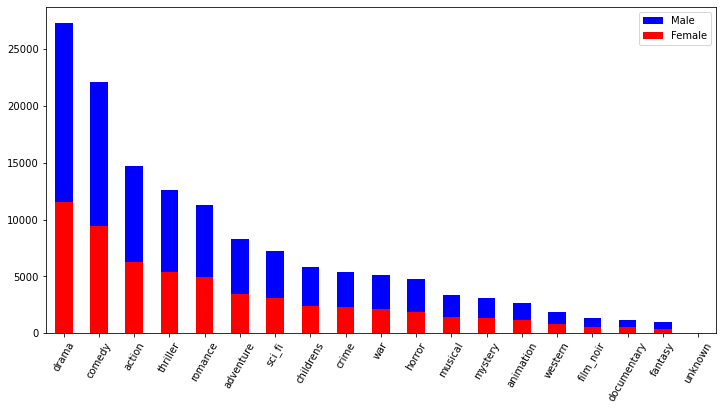

In [49]:
plt.figure(figsize=(12, 6))

temp_df.M.sort_values(ascending=False).plot(kind='bar', color='blue', label="Male")
temp_df.F.sort_values(ascending=False).plot(kind='bar', color='red', label="Female")
plt.legend()
plt.xticks(rotation=60)
plt.show()


Apparently we only have ratings on movies for 2 years, approximately when the movieLens site started to gather ratings

In [52]:
rating.groupby(rating.timestamp.dt.year).size()

timestamp
1997    52899
1998    47101
dtype: int64

In [53]:
rating_user_df.groupby([rating_user_df.timestamp.dt.year, 'gender']).size()

timestamp  gender
1997       F         18311
           M         34550
1998       F         11474
           M         35497
dtype: int64

Males tend to rate more than females

In [54]:
rating_user_df.groupby([rating_user_df.timestamp.dt.year, 'age_group']).size()

timestamp  age_group    
1997       Gradeschooler       91
           Midlife          18482
           Old               2439
           Teenager          4459
           Young            27390
1998       Gradeschooler       75
           Midlife          18020
           Old               2832
           Teenager          3453
           Young            22591
dtype: int64

Type of rating people usually give

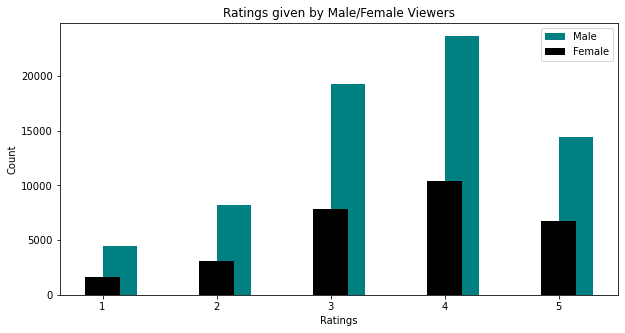

In [55]:
temp_df = rating_user_df.groupby(['gender', 'rating']).size()
plt.figure(figsize=(10, 5))
m_temp_df = temp_df.M.sort_values(ascending=False)
f_temp_df = temp_df.F.sort_values(ascending=False)

plt.bar(x=m_temp_df.index, height=m_temp_df.values, label="Male", align="edge", width=0.3, color='teal')
plt.bar(x=f_temp_df.index, height=f_temp_df.values, label="Female", width=0.3, color='black')
plt.title('Ratings given by Male/Female Viewers')
plt.legend()
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

In [56]:
def draw_horizontal_movie_bar(movie_titles, ratings_count, title=''):
    plt.figure(figsize=(12, 7))
    sns.barplot(y=movie_titles, x=ratings_count, orient='h')
    plt.title(title)
    plt.ylabel('Movies')
    plt.xlabel('Count')
    plt.show()

Movies that have been rated the most

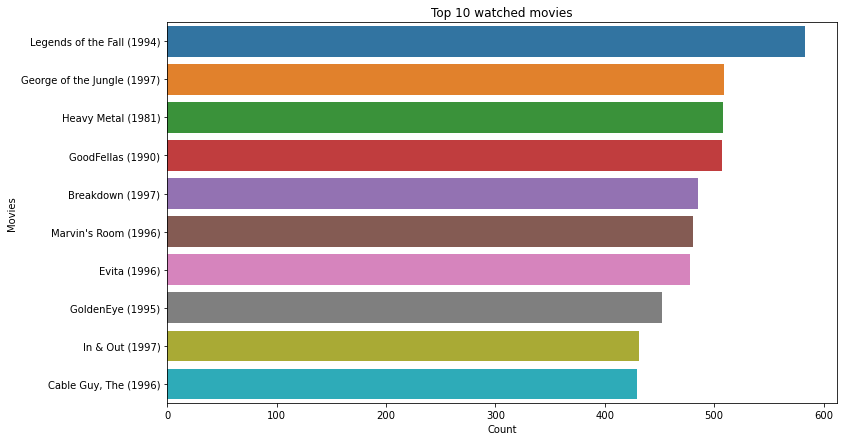

In [58]:
top_ten_rated_movies = rating_movie_df.groupby('movie_id').size().sort_values(ascending=False)[:10]
top_ten_movie_titles = movie.iloc[top_ten_rated_movies.index].movie_title

draw_horizontal_movie_bar(top_ten_movie_titles.values, top_ten_rated_movies.values, 'Top 10 watched movies')

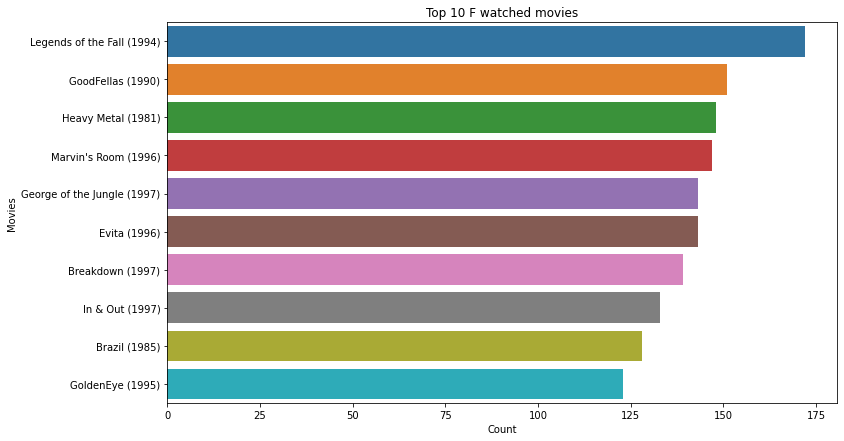

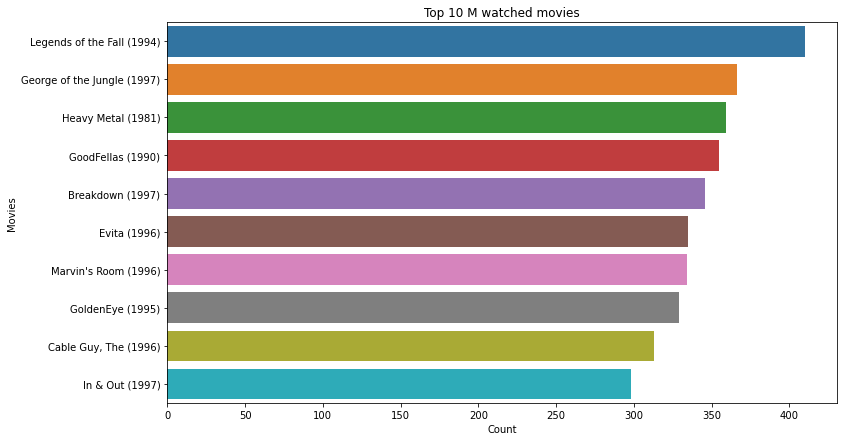

In [59]:
top_rated_movies_gender_wise = rating_user_movie_df.groupby(['gender','movie_id']).size()

for index_label in top_rated_movies_gender_wise.index.get_level_values(0).unique():

    top_10_userkind_rated_movies = top_rated_movies_gender_wise[index_label].sort_values(ascending=False)[:10]
    top_10_userkind_rated_movie_titles = movie.iloc[top_10_userkind_rated_movies.index].movie_title
    draw_horizontal_movie_bar(top_10_userkind_rated_movie_titles.values, top_10_userkind_rated_movies.values, f'Top 10 {index_label} watched movies')

Movie rating in function of the age

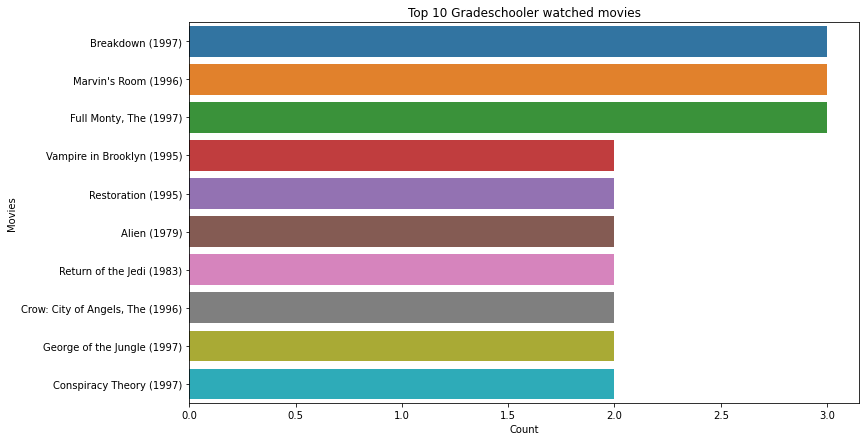

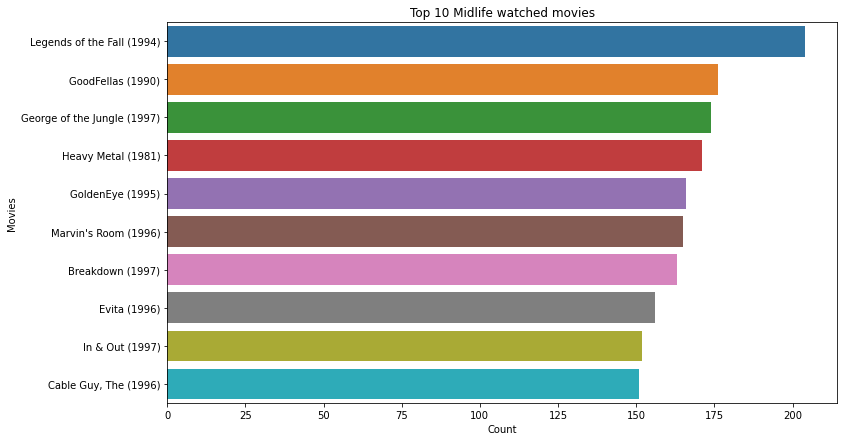

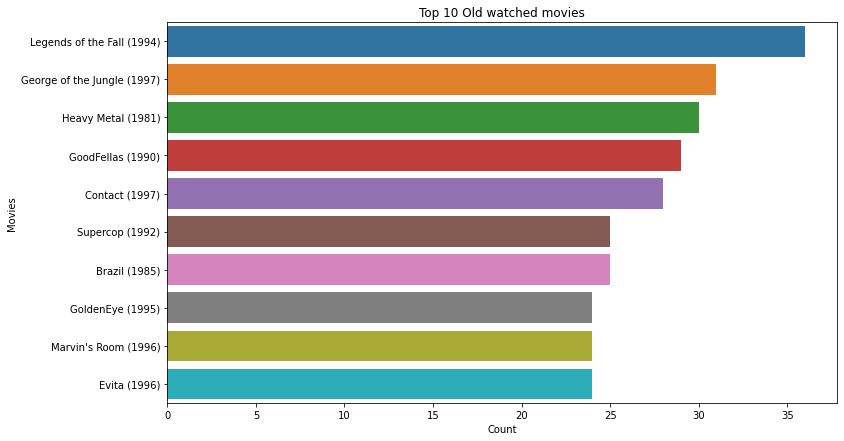

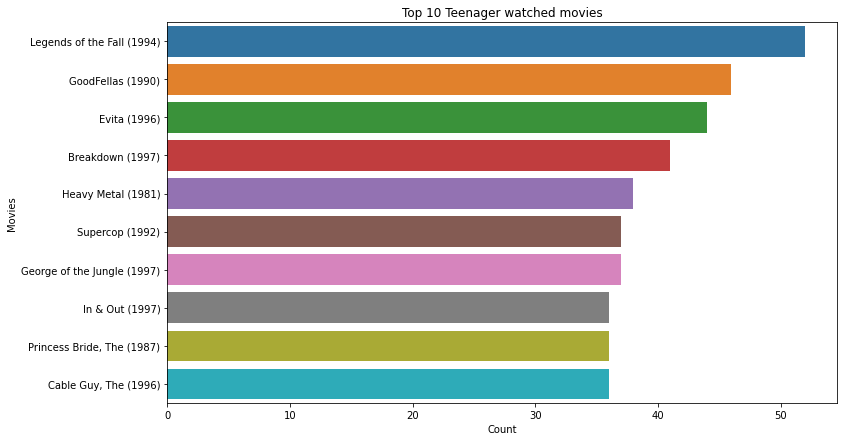

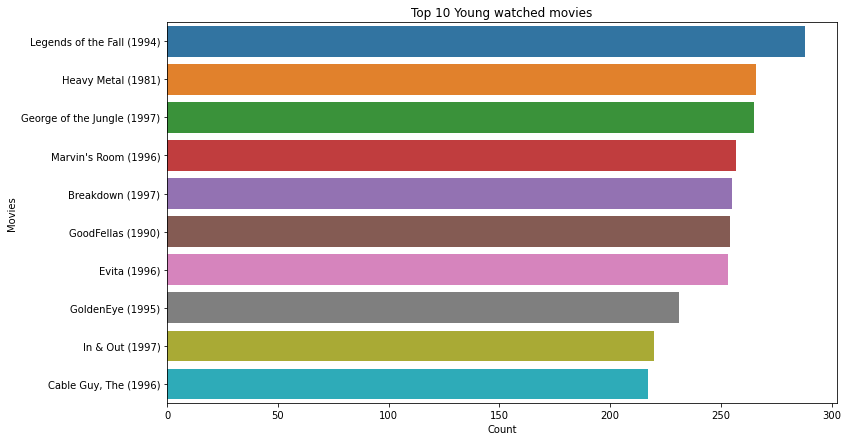

In [60]:
top_rated_movies_age_group_wise = rating_user_movie_df.groupby(['age_group','movie_id']).size()

for index_label in top_rated_movies_age_group_wise.index.get_level_values(0).unique():
    top_10_userkind_rated_movies = top_rated_movies_age_group_wise[index_label].sort_values(ascending=False)[:10]
    top_10_userkind_rated_movie_titles = movie.iloc[top_10_userkind_rated_movies.index].movie_title
    draw_horizontal_movie_bar(top_10_userkind_rated_movie_titles.values, top_10_userkind_rated_movies.values, f'Top 10 {index_label} watched movies')


Let us check what are the most loved movies


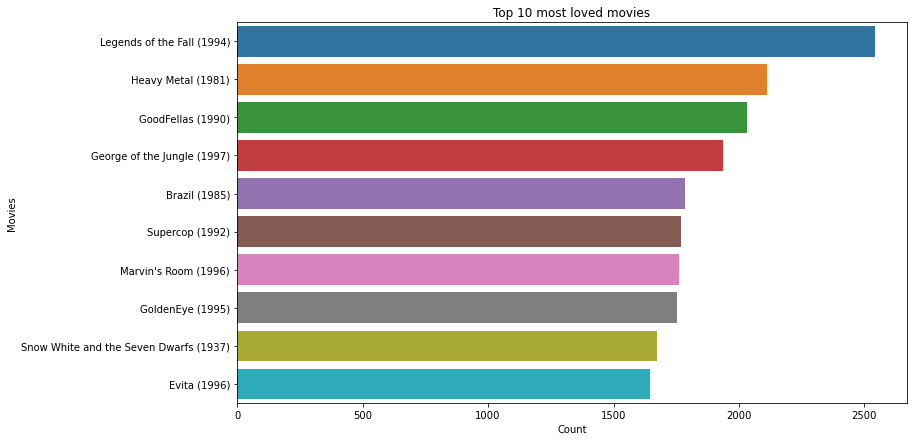

In [61]:
top_ten_most_loved_movies = rating_movie_df.groupby('movie_id').sum().rating.sort_values(ascending=False)[:10]
top_ten_most_loved_movie_titles = movie.iloc[top_ten_most_loved_movies.index].movie_title

draw_horizontal_movie_bar(top_ten_most_loved_movie_titles.values, top_ten_most_loved_movies.values, 'Top 10 most loved movies')

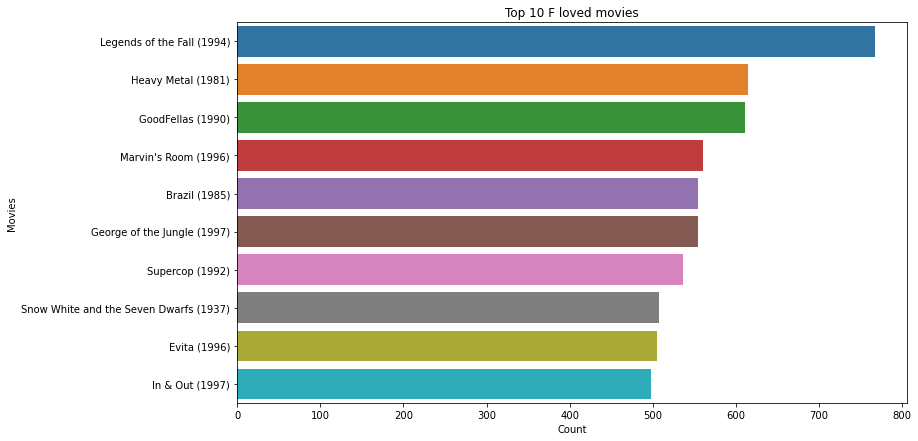

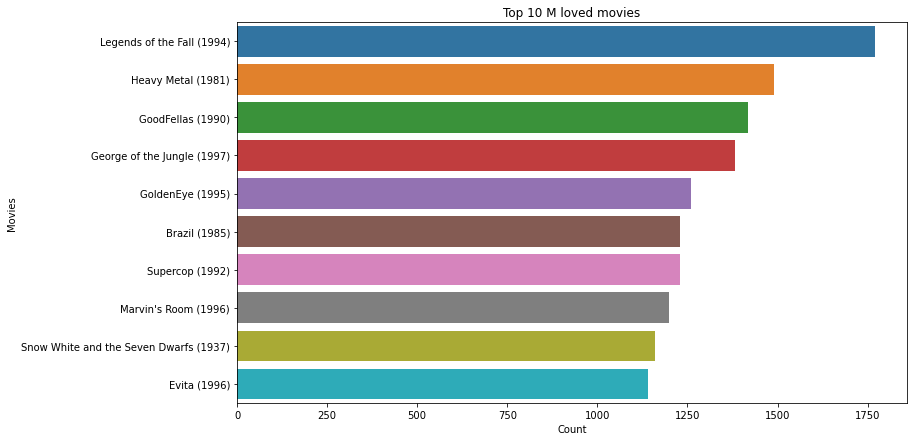

In [62]:
most_loved_movies_gender_wise = rating_user_movie_df.groupby(['gender','movie_id']).sum().rating

for index_label in most_loved_movies_gender_wise.index.get_level_values(0).unique():

    top_10_userkind_loved_movies = most_loved_movies_gender_wise[index_label].sort_values(ascending=False)[:10]
    top_10_userkind_loved_movie_titles = movie.iloc[top_10_userkind_loved_movies.index].movie_title
    draw_horizontal_movie_bar(top_10_userkind_loved_movie_titles.values, top_10_userkind_loved_movies.values, f'Top 10 {index_label} loved movies')

most loved movies in terms of age

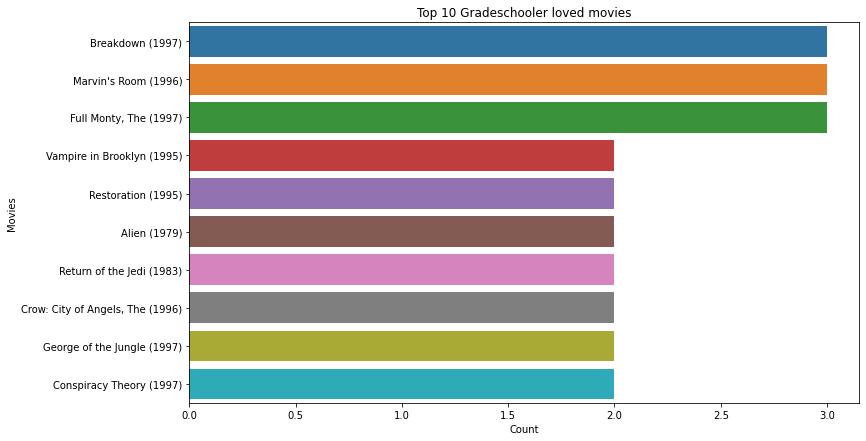

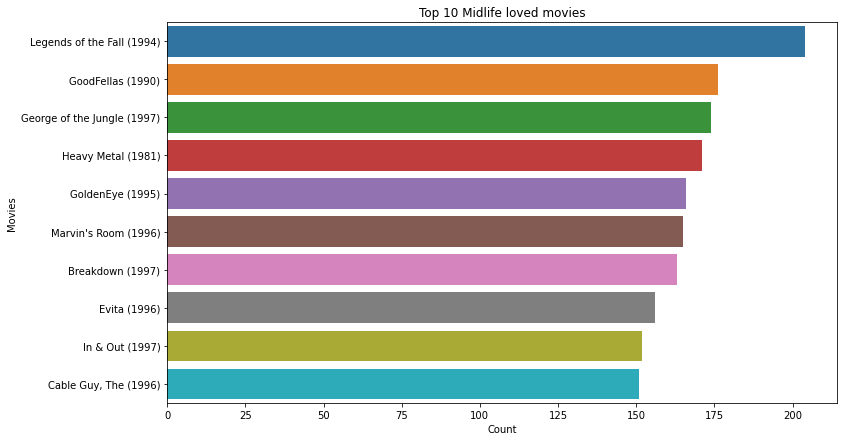

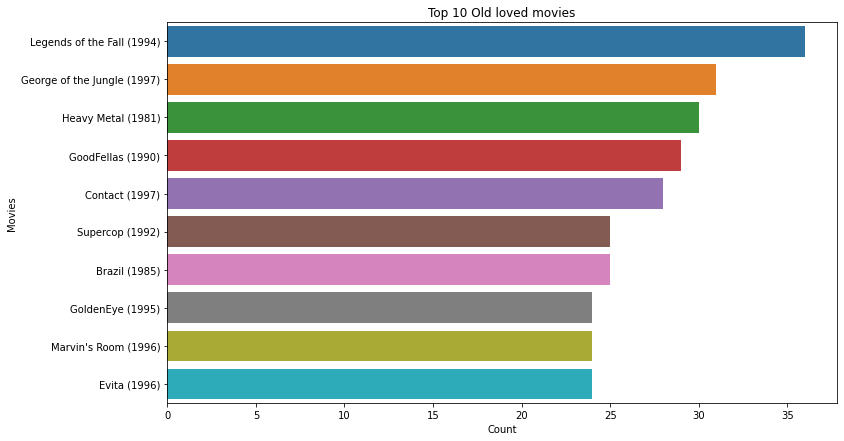

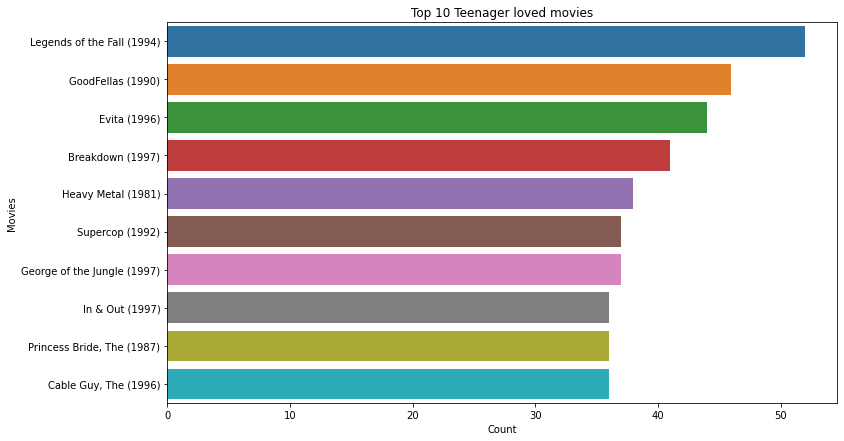

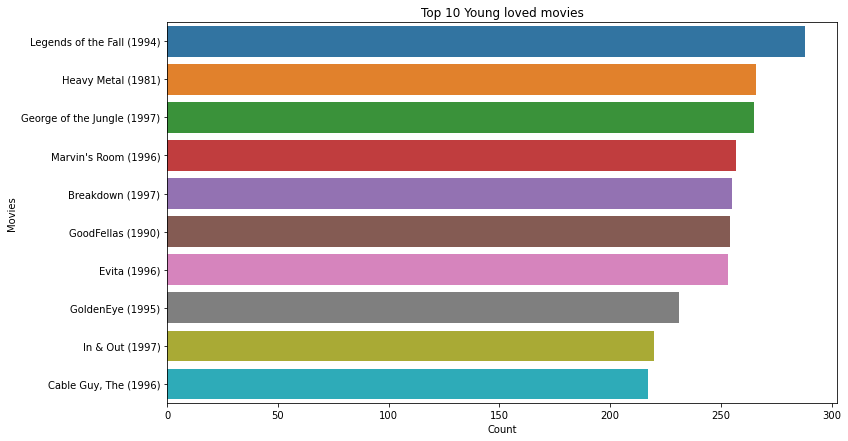

In [63]:
most_loved_movies_age_group_wise = rating_user_movie_df.groupby(['age_group','movie_id']).sum().rating

for index_label in most_loved_movies_age_group_wise.index.get_level_values(0).unique():
    top_10_userkind_loved_movies = top_rated_movies_age_group_wise[index_label].sort_values(ascending=False)[:10]
    top_10_userkind_loved_movie_titles = movie.iloc[top_10_userkind_loved_movies.index].movie_title
    draw_horizontal_movie_bar(top_10_userkind_loved_movie_titles.values, top_10_userkind_loved_movies.values, f'Top 10 {index_label} loved movies')

In [65]:
movies_ratings_sum = rating_user_movie_df.groupby('movie_id').sum().rating.sort_values()
movies_ratings_sum.index = movie.iloc[movies_ratings_sum.index].movie_title
# Will show movies with 0 < total_rating<= 10
lowest_rated_movies = movies_ratings_sum[movies_ratings_sum <= 10]

Then Below is the world Cloud of the worst rated movies

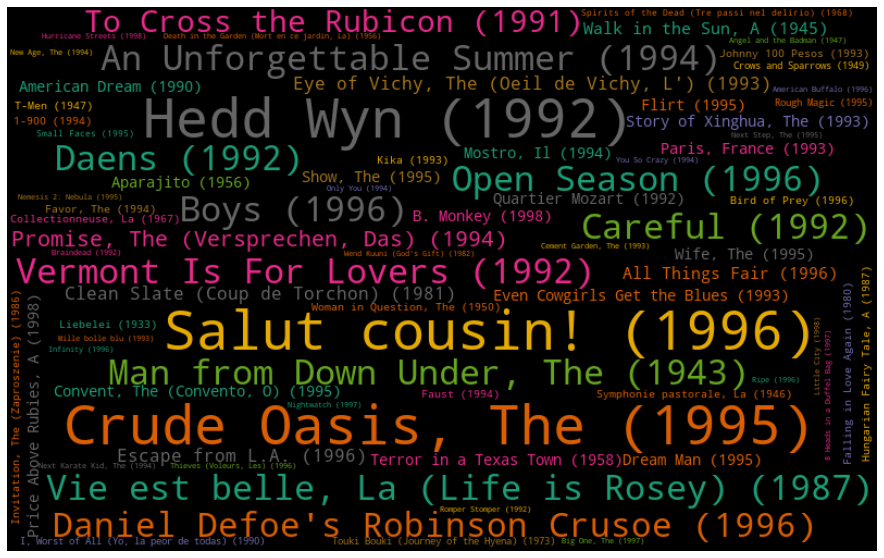

In [66]:
wordcloud = WordCloud(min_font_size=7, width=800, height=500, random_state=21, max_font_size=50, relative_scaling=0.5, colormap='Dark2')
# Substracted lowest_rated_movies from 11 so that we can have greater font size of least rated movies.
wordcloud.generate_from_frequencies(frequencies=(11-lowest_rated_movies).to_dict())
plt.figure(figsize=(16,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()